In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision

In [2]:
# Load training features
combined_sd7 = torch.load('combined_sd7.pt')
combined_sd10 = torch.load('combined_sd10.pt')
# Load training features
cond_7 = torch.load('cond7.pt')
cond_10 = torch.load('cond10.pt')
# Load training features
ex7 = torch.load('ex7.pt')
ex10 = torch.load('ex10.pt')
# Load training features
sd7 = torch.load('sd7_one.pt')
sd10 = torch.load('sd10_one.pt')

C:\Users\k54739\AppData\Local\Temp\ipykernel_9872\325273452.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_sd7 = torch.load('combined_sd7.pt')
C:\Users\k54739\



combined_sd7_numpy = combined_sd7.numpy()
combined_sd10_numpy = combined_sd10.numpy()

In [3]:
print(combined_sd7.shape)
print(combined_sd10.shape)

torch.Size([638, 512])
torch.Size([638, 512])



cond_7_numpy = cond_7.numpy()
cond_10_numpy = cond_10.numpy()

In [4]:
cond_7.shape


torch.Size([130, 512])

In [5]:
cond_10.shape

torch.Size([130, 512])




ex7_numpy = ex7.numpy()
ex10_numpy = ex10.numpy()


In [6]:
print(ex7.shape)
print(ex10.shape)

torch.Size([38, 512])
torch.Size([38, 512])





sd7_numpy = sd7.numpy()
sd10_numpy = sd10.numpy()


In [7]:
print(sd7.shape)
print(sd10.shape)

torch.Size([29, 512])
torch.Size([29, 512])


In [8]:
import joblib
# Load the scalers from disk
scaler_day7 = joblib.load('scaler_day7.pkl')
scaler_day10 = joblib.load('scaler_day10.pkl')

print("Scalers loaded!")

Scalers loaded!


combined_sd7_numpy = scaler_day7.transform(combined_sd7_numpy)
combined_sd10_numpy = scaler_day10.transform(combined_sd10_numpy)

combined_sd7_minmax = torch.tensor(combined_sd7_numpy)
combined_sd10_minmax = torch.tensor(combined_sd10_numpy)

cond_7_numpy = scaler_day7.transform(cond_7_numpy)
cond_10_numpy = scaler_day10.transform(cond_10_numpy)

cond7_minmax = torch.tensor(cond_7_numpy)
cond10_minmax = torch.tensor(cond_10_numpy)

ex7_numpy = scaler_day7.transform(ex7_numpy)
ex10_numpy = scaler_day10.transform(ex10_numpy)

ex7_minmax = torch.tensor(ex7_numpy)
ex10_minmax = torch.tensor(ex10_numpy)


sd7_numpy = scaler_day7.transform(sd7_numpy)
sd10_numpy = scaler_day10.transform(sd10_numpy)

sd7_minmax = torch.tensor(sd7_numpy)
sd10_minmax = torch.tensor(sd10_numpy)

In [9]:
import torch
from sklearn.preprocessing import MinMaxScaler

def scale_tensor(scaler, tensor):
    """
    Scales a tensor using the provided MinMaxScaler.

    Args:
        scaler (MinMaxScaler): The MinMaxScaler to use for scaling.
        tensor (torch.Tensor): The tensor to scale.

    Returns:
        torch.Tensor: The scaled tensor.
    """
    tensor_numpy = tensor.numpy()  # Convert tensor to numpy
    tensor_scaled_numpy = scaler.transform(tensor_numpy)  # Apply Min-Max scaling
    tensor_scaled = torch.tensor(tensor_scaled_numpy)  # Convert back to torch tensor
    return tensor_scaled

# Example usage for different datasets
combined_sd7_minmax = scale_tensor(scaler_day7, combined_sd7)
combined_sd10_minmax = scale_tensor(scaler_day10, combined_sd10)

cond7_minmax = scale_tensor(scaler_day7, cond_7)
cond10_minmax = scale_tensor(scaler_day10, cond_10)

ex7_minmax = scale_tensor(scaler_day7, ex7)
ex10_minmax = scale_tensor(scaler_day10, ex10)

sd7_minmax = scale_tensor(scaler_day7, sd7)
sd10_minmax = scale_tensor(scaler_day10, sd10)


In [10]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [12]:
# Define the directory where models are saved
#load_dir = r'C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled'

# Load a specific fold's best model
model = FeaturePredictor()
load_path = os.path.join('featwiseNorm_model_5.pth')
model.load_state_dict(torch.load(load_path))
model.to(device)
model.eval()

print(f"Loaded model from {load_path}")

C:\Users\k54739\AppData\Local\Temp\ipykernel_9872\1594053013.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


Loaded model from featwiseNorm_model_5.pth


# all metrics added:

In [13]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = combined_sd7_minmax.to(device)
train_day10_feats_minmaxed = combined_sd10_minmax.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []
l1_distances = []
pearson_correlations = []
dot_products = []
jaccard_similarities = []
hamming_distances = []
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feats = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
    cosine_distances.append(cosine_distance)
    
    # Compute L1 distance
    l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
    l1_distances.append(l1_distance)
    
    # Compute Pearson Correlation
    combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
    pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
    pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
    pearson_correlations.append(pearson_corr.item())
    
    # Compute Inner Product (Dot Product)
    dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
    dot_products.append(dot_product)
    
    # Compute Jaccard Similarity (thresholding features to binary)
    bin_pred = (predicted_day10.flatten() > 0.5).int()
    bin_true = (train_day10_feats.flatten() > 0.5).int()
    intersection = (bin_pred & bin_true).sum().item()
    union = (bin_pred | bin_true).sum().item()
    jaccard_similarity = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard_similarity)
    
    # Compute Hamming Distance (binary representation)
    hamming_distance = (bin_pred != bin_true).sum().item()
    hamming_distances.append(hamming_distance)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)


# Print some example metrics for the first feature vector
print(f"Example metrics for the first feature vector:")
print(f"MSE: {mse_values[0]:.4f}")
print(f"Euclidean Distance: {euclidean_distances[0]:.4f}")
print(f"Cosine Distance: {cosine_distances[0]:.4f}")
print(f"L1 Distance: {l1_distances[0]:.4f}")
print(f"Pearson Correlation: {pearson_correlations[0]:.4f}")
print(f"Dot Product: {dot_products[0]:.4f}")
print(f"Jaccard Similarity: {jaccard_similarities[0]:.4f}")
print(f"Hamming Distance: {hamming_distances[0]:.4f}")
print(f"Mahalanobis Distance: {mahalanobis_distances[0]:.4f}")


Example metrics for the first feature vector:
MSE: 0.0130
Euclidean Distance: 2.5785
Cosine Distance: 0.0566
L1 Distance: 44.7211
Pearson Correlation: 0.8998
Dot Product: 51.5648
Jaccard Similarity: 0.5377
Hamming Distance: 49.0000
Mahalanobis Distance: 127.0576


In [14]:
import pandas as pd

# Create a DataFrame with all the metrics
data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances,  # List of Cosine distances
    "L1 Distance": l1_distances,  # List of L1 distances
    "Pearson Correlation": pearson_correlations,  # List of Pearson correlation values
    "Dot Product": dot_products,  # List of dot product values
    "Jaccard Similarity": jaccard_similarities,  # List of Jaccard similarities
    "Hamming Distance": hamming_distances,  # List of Hamming distances
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "FeatNorm_all_metrics_combined_sd.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"All metrics saved to {csv_file_name}")


All metrics saved to FeatNorm_all_metrics_combined_sd.csv


In [15]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = cond7_minmax.to(device)
train_day10_feats_minmaxed = cond10_minmax.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []
l1_distances = []
pearson_correlations = []
dot_products = []
jaccard_similarities = []
hamming_distances = []
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feats = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
    cosine_distances.append(cosine_distance)
    
    # Compute L1 distance
    l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
    l1_distances.append(l1_distance)
    
    # Compute Pearson Correlation
    combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
    pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
    pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
    pearson_correlations.append(pearson_corr.item())
    
    # Compute Inner Product (Dot Product)
    dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
    dot_products.append(dot_product)
    
    # Compute Jaccard Similarity (thresholding features to binary)
    bin_pred = (predicted_day10.flatten() > 0.5).int()
    bin_true = (train_day10_feats.flatten() > 0.5).int()
    intersection = (bin_pred & bin_true).sum().item()
    union = (bin_pred | bin_true).sum().item()
    jaccard_similarity = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard_similarity)
    
    # Compute Hamming Distance (binary representation)
    hamming_distance = (bin_pred != bin_true).sum().item()
    hamming_distances.append(hamming_distance)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)


# Print some example metrics for the first feature vector
print(f"Example metrics for the first feature vector:")
print(f"MSE: {mse_values[0]:.4f}")
print(f"Euclidean Distance: {euclidean_distances[0]:.4f}")
print(f"Cosine Distance: {cosine_distances[0]:.4f}")
print(f"L1 Distance: {l1_distances[0]:.4f}")
print(f"Pearson Correlation: {pearson_correlations[0]:.4f}")
print(f"Dot Product: {dot_products[0]:.4f}")
print(f"Jaccard Similarity: {jaccard_similarities[0]:.4f}")
print(f"Hamming Distance: {hamming_distances[0]:.4f}")
print(f"Mahalanobis Distance: {mahalanobis_distances[0]:.4f}")


Example metrics for the first feature vector:
MSE: 0.3159
Euclidean Distance: 12.7183
Cosine Distance: 0.6684
L1 Distance: 133.5468
Pearson Correlation: 0.0083
Dot Product: 26.4688
Jaccard Similarity: 0.0598
Hamming Distance: 110.0000
Mahalanobis Distance: 1710.7633


In [16]:
import pandas as pd

# Create a DataFrame with all the metrics
data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances,  # List of Cosine distances
    "L1 Distance": l1_distances,  # List of L1 distances
    "Pearson Correlation": pearson_correlations,  # List of Pearson correlation values
    "Dot Product": dot_products,  # List of dot product values
    "Jaccard Similarity": jaccard_similarities,  # List of Jaccard similarities
    "Hamming Distance": hamming_distances,  # List of Hamming distances
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "FeatNorm_all_metrics_control.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"All metrics saved to {csv_file_name}")


All metrics saved to FeatNorm_all_metrics_control.csv


In [1]:
# ex

In [17]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = ex7_minmax.to(device)
train_day10_feats_minmaxed = ex10_minmax.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []
l1_distances = []
pearson_correlations = []
dot_products = []
jaccard_similarities = []
hamming_distances = []
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feats = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
    cosine_distances.append(cosine_distance)
    
    # Compute L1 distance
    l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
    l1_distances.append(l1_distance)
    
    # Compute Pearson Correlation
    combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
    pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
    pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
    pearson_correlations.append(pearson_corr.item())
    
    # Compute Inner Product (Dot Product)
    dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
    dot_products.append(dot_product)
    
    # Compute Jaccard Similarity (thresholding features to binary)
    bin_pred = (predicted_day10.flatten() > 0.5).int()
    bin_true = (train_day10_feats.flatten() > 0.5).int()
    intersection = (bin_pred & bin_true).sum().item()
    union = (bin_pred | bin_true).sum().item()
    jaccard_similarity = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard_similarity)
    
    # Compute Hamming Distance (binary representation)
    hamming_distance = (bin_pred != bin_true).sum().item()
    hamming_distances.append(hamming_distance)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)

# Print some example metrics for the first feature vector
print(f"Example metrics for the first feature vector:")
print(f"MSE: {mse_values[0]:.4f}")
print(f"Euclidean Distance: {euclidean_distances[0]:.4f}")
print(f"Cosine Distance: {cosine_distances[0]:.4f}")
print(f"L1 Distance: {l1_distances[0]:.4f}")
print(f"Pearson Correlation: {pearson_correlations[0]:.4f}")
print(f"Dot Product: {dot_products[0]:.4f}")
print(f"Jaccard Similarity: {jaccard_similarities[0]:.4f}")
print(f"Hamming Distance: {hamming_distances[0]:.4f}")
print(f"Mahalanobis Distance: {mahalanobis_distances[0]:.4f}")


Example metrics for the first feature vector:
MSE: 12.8466
Euclidean Distance: 81.1015
Cosine Distance: 0.9432
L1 Distance: 313.3245
Pearson Correlation: -0.0999
Dot Product: 28.2800
Jaccard Similarity: 0.0124
Hamming Distance: 159.0000
Mahalanobis Distance: 6156.6626


In [18]:
import pandas as pd

# Create a DataFrame with all the metrics
data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances,  # List of Cosine distances
    "L1 Distance": l1_distances,  # List of L1 distances
    "Pearson Correlation": pearson_correlations,  # List of Pearson correlation values
    "Dot Product": dot_products,  # List of dot product values
    "Jaccard Similarity": jaccard_similarities,  # List of Jaccard similarities
    "Hamming Distance": hamming_distances,  # List of Hamming distances
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "FeatNorm_all_metrics_ex.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"All metrics saved to {csv_file_name}")


All metrics saved to FeatNorm_all_metrics_ex.csv


In [2]:
#sd

In [19]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = sd7_minmax.to(device)
train_day10_feats_minmaxed = sd10_minmax.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []
l1_distances = []
pearson_correlations = []
dot_products = []
jaccard_similarities = []
hamming_distances = []
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feats = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
    cosine_distances.append(cosine_distance)
    
    # Compute L1 distance
    l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
    l1_distances.append(l1_distance)
    
    # Compute Pearson Correlation
    combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
    pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
    pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
    pearson_correlations.append(pearson_corr.item())
    
    # Compute Inner Product (Dot Product)
    dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
    dot_products.append(dot_product)
    
    # Compute Jaccard Similarity (thresholding features to binary)
    bin_pred = (predicted_day10.flatten() > 0.5).int()
    bin_true = (train_day10_feats.flatten() > 0.5).int()
    intersection = (bin_pred & bin_true).sum().item()
    union = (bin_pred | bin_true).sum().item()
    jaccard_similarity = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard_similarity)
    
    # Compute Hamming Distance (binary representation)
    hamming_distance = (bin_pred != bin_true).sum().item()
    hamming_distances.append(hamming_distance)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)

# Print some example metrics for the first feature vector
print(f"Example metrics for the first feature vector:")
print(f"MSE: {mse_values[0]:.4f}")
print(f"Euclidean Distance: {euclidean_distances[0]:.4f}")
print(f"Cosine Distance: {cosine_distances[0]:.4f}")
print(f"L1 Distance: {l1_distances[0]:.4f}")
print(f"Pearson Correlation: {pearson_correlations[0]:.4f}")
print(f"Dot Product: {dot_products[0]:.4f}")
print(f"Jaccard Similarity: {jaccard_similarities[0]:.4f}")
print(f"Hamming Distance: {hamming_distances[0]:.4f}")
print(f"Mahalanobis Distance: {mahalanobis_distances[0]:.4f}")


Example metrics for the first feature vector:
MSE: 0.0130
Euclidean Distance: 2.5785
Cosine Distance: 0.0566
L1 Distance: 44.7211
Pearson Correlation: 0.8998
Dot Product: 51.5648
Jaccard Similarity: 0.5377
Hamming Distance: 49.0000
Mahalanobis Distance: 856.9639


In [20]:
import pandas as pd

# Create a DataFrame with all the metrics
data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances,  # List of Cosine distances
    "L1 Distance": l1_distances,  # List of L1 distances
    "Pearson Correlation": pearson_correlations,  # List of Pearson correlation values
    "Dot Product": dot_products,  # List of dot product values
    "Jaccard Similarity": jaccard_similarities,  # List of Jaccard similarities
    "Hamming Distance": hamming_distances,  # List of Hamming distances
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "FeatNorm_all_metrics_sd.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"All metrics saved to {csv_file_name}")


All metrics saved to FeatNorm_all_metrics_sd.csv


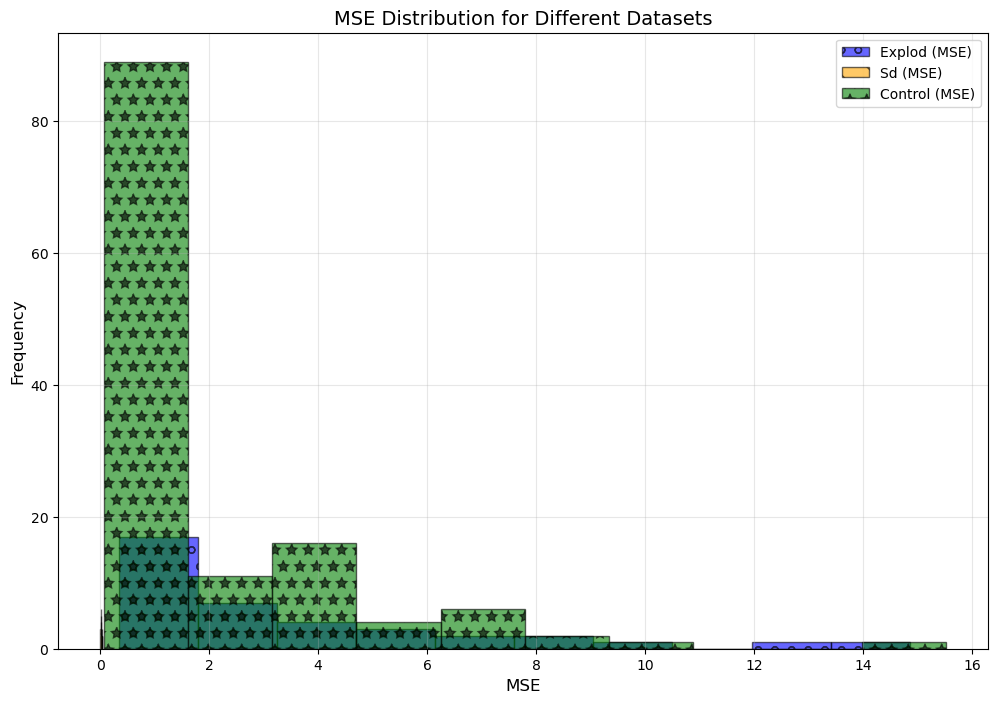

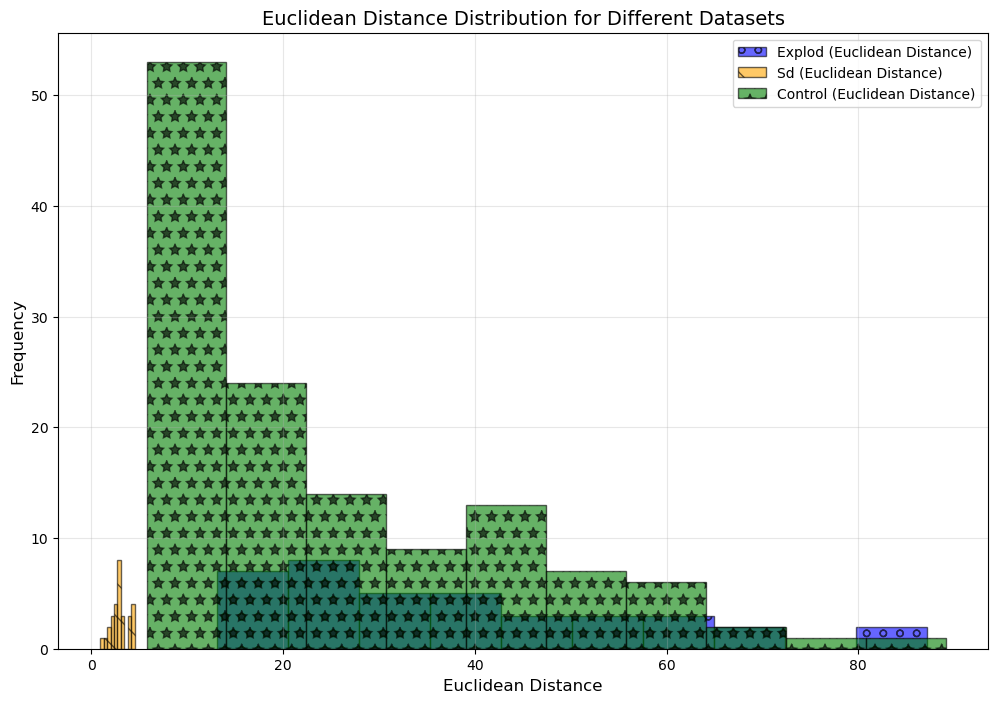

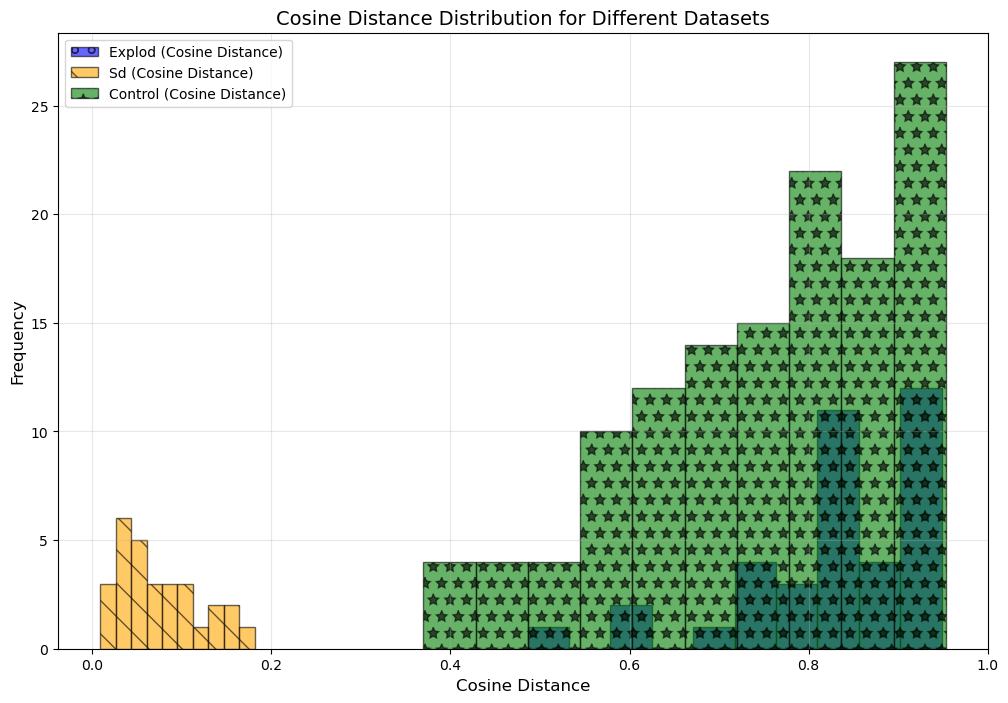

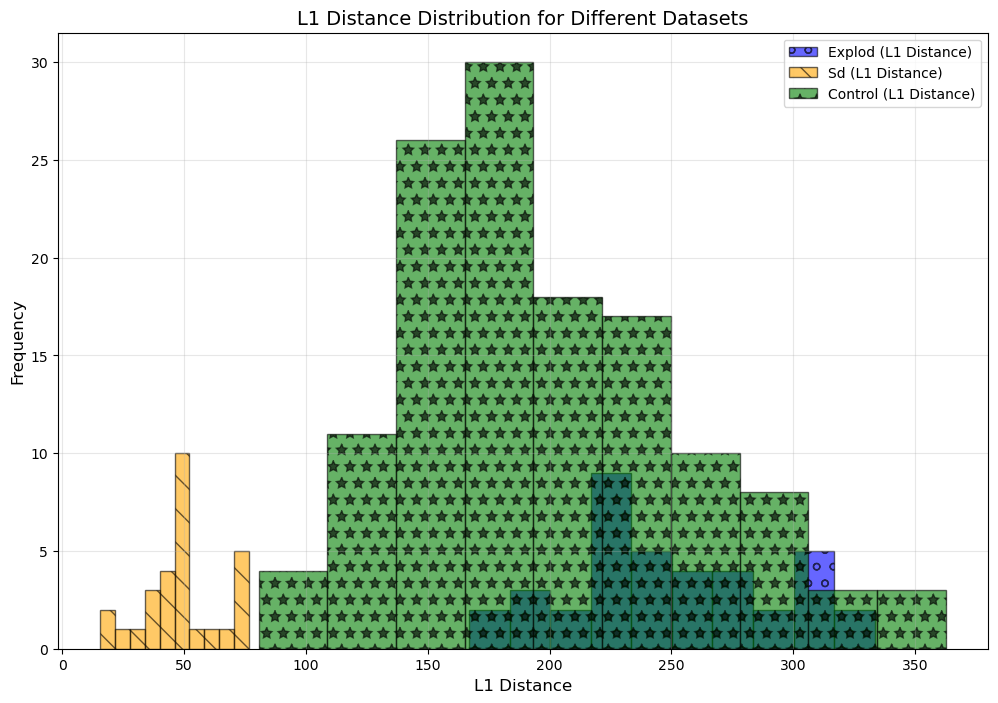

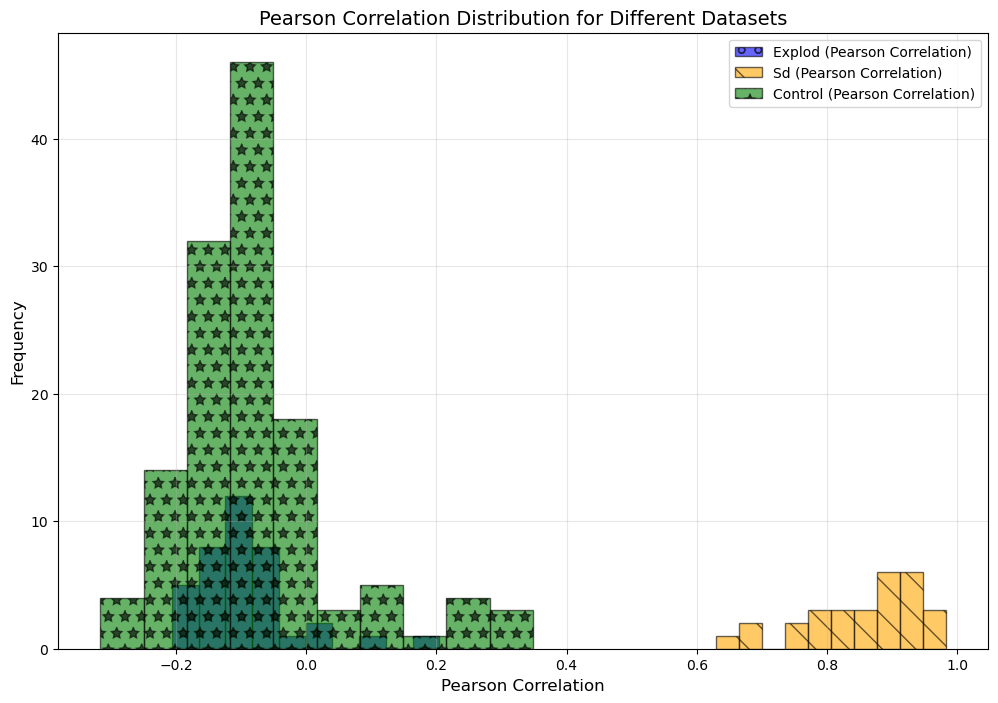

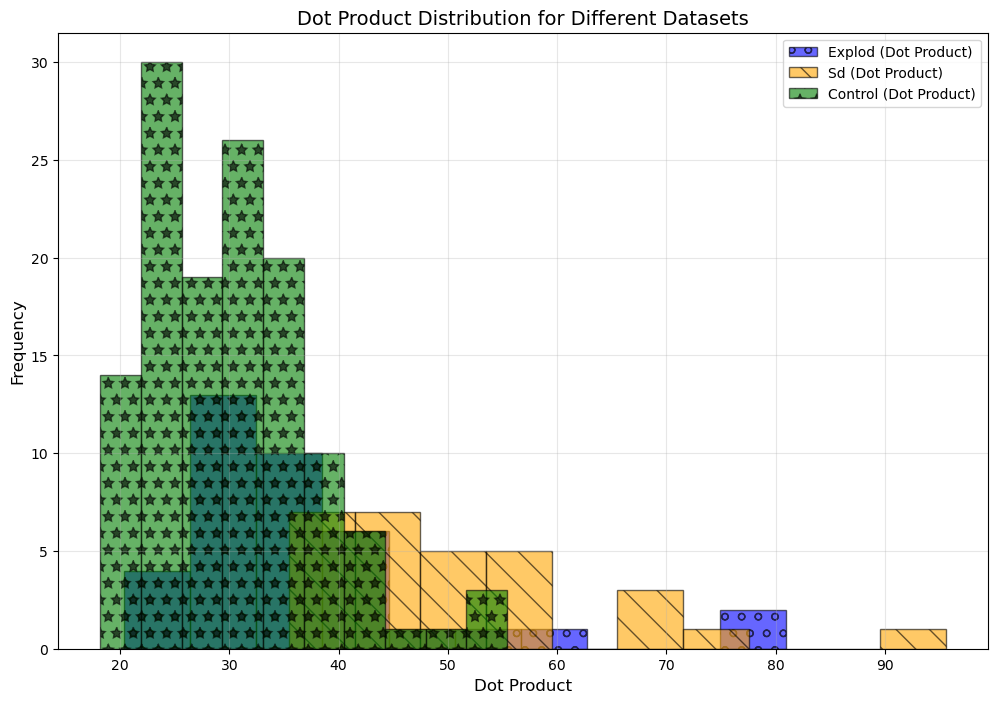

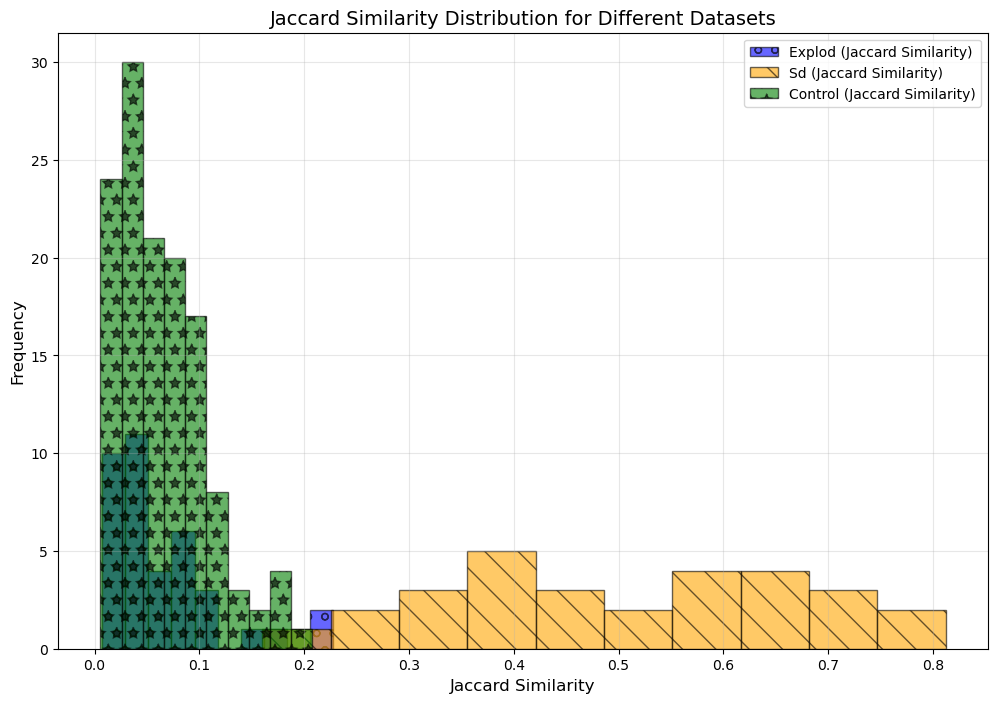

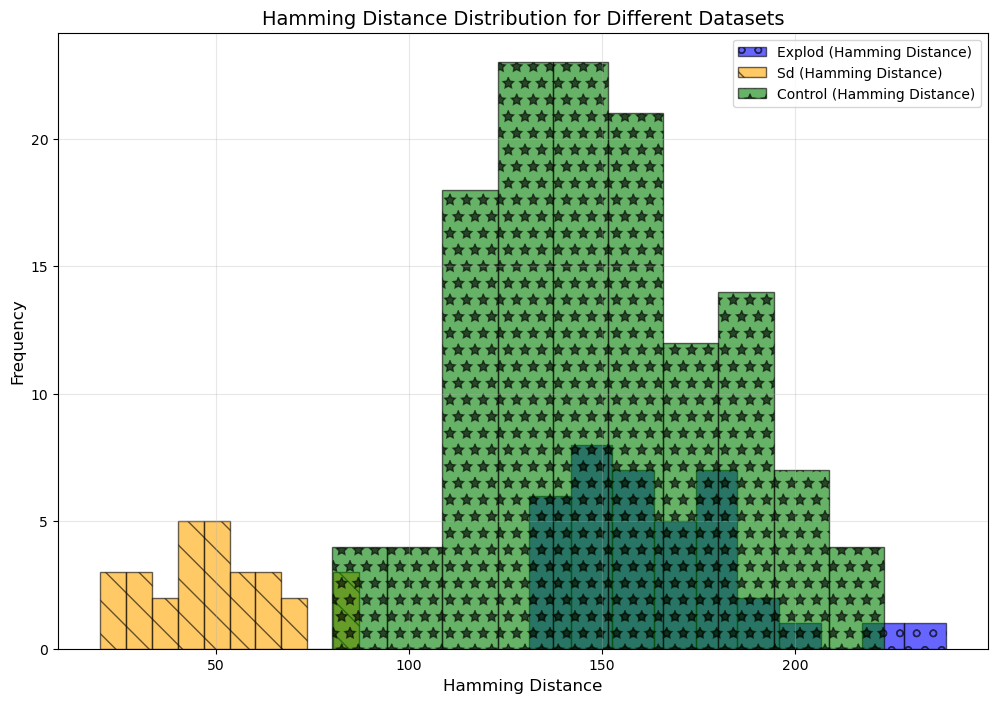

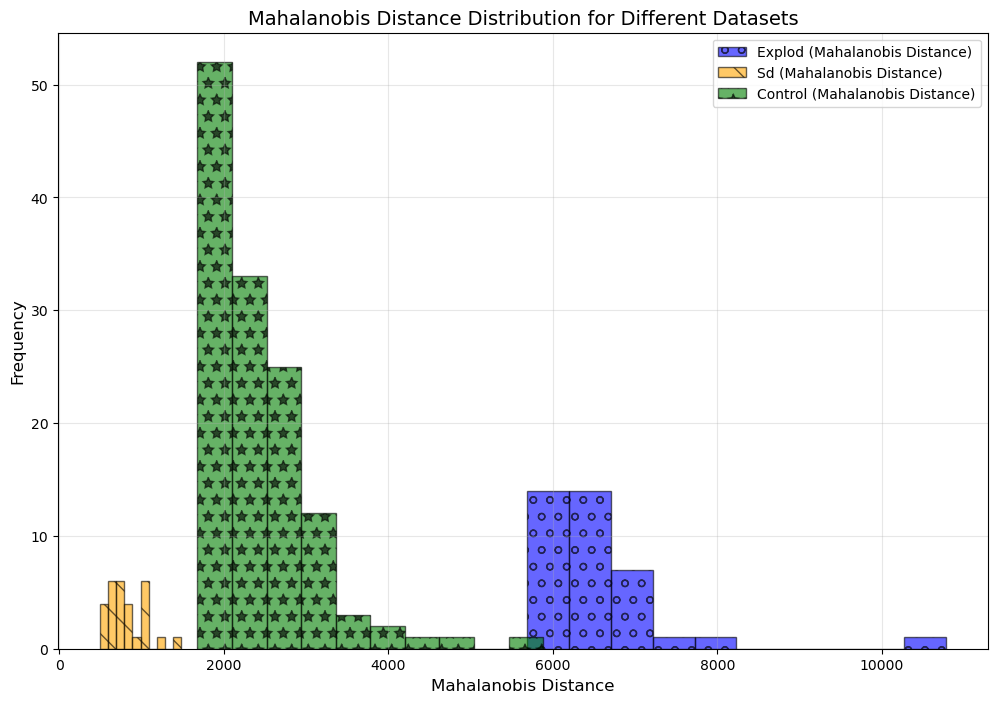

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("FeatNorm_all_metrics_ex.csv"),
    "sd": pd.read_csv("FeatNorm_all_metrics_sd.csv"),
    "control": pd.read_csv("FeatNorm_all_metrics_control.csv")
}

# Prepare all metrics
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance"
]

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        if metric_name in df.columns:
            values = df[metric_name].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                hatch=hatch_styles[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


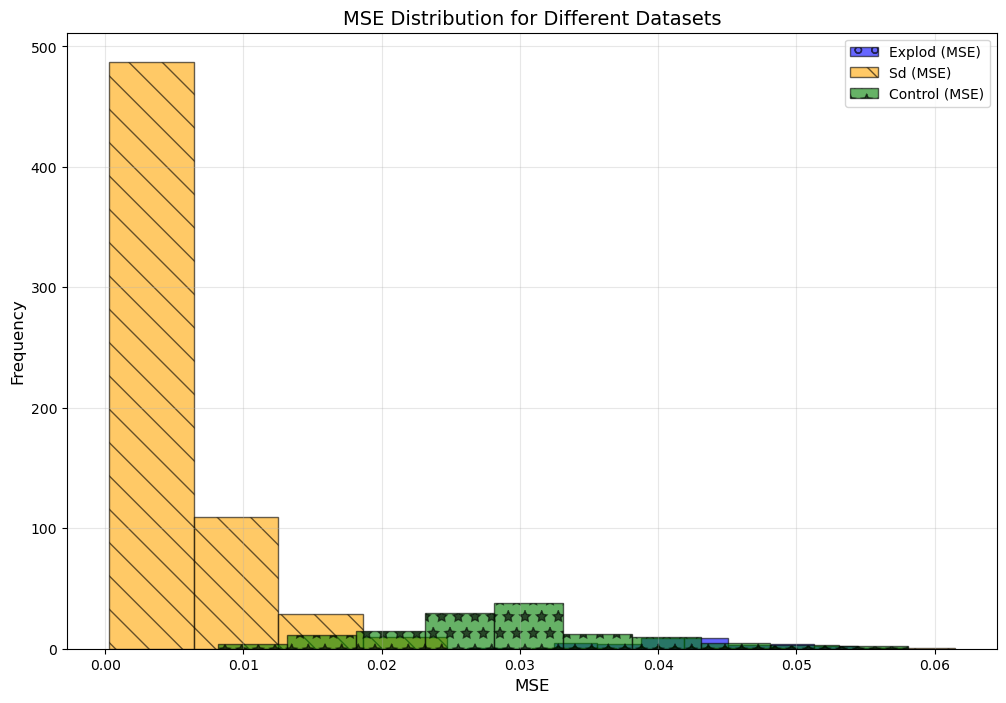

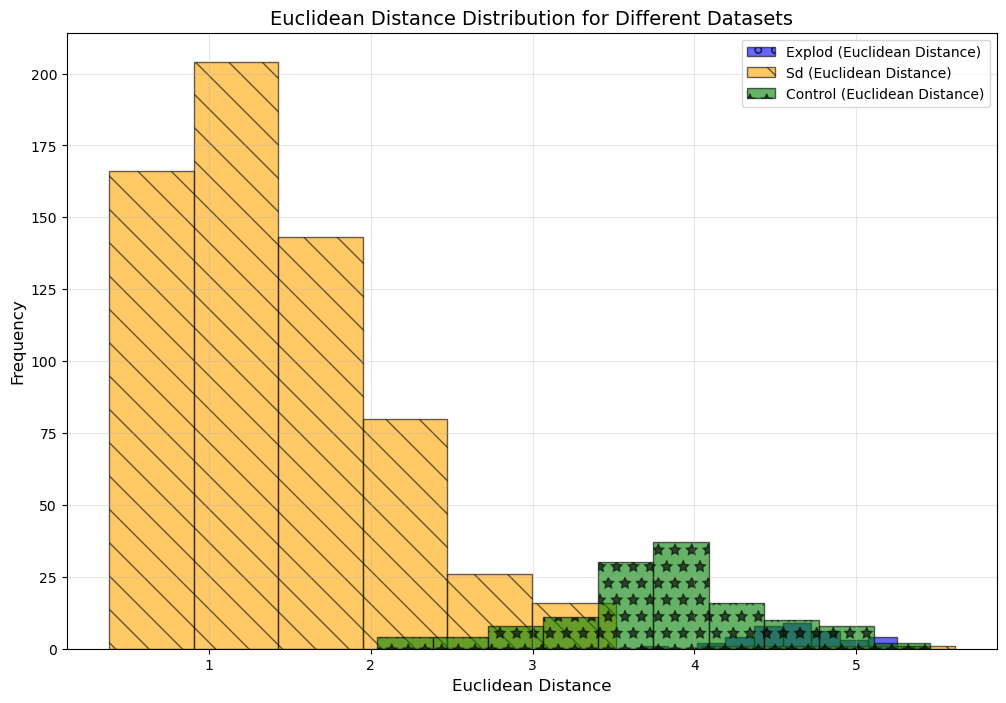

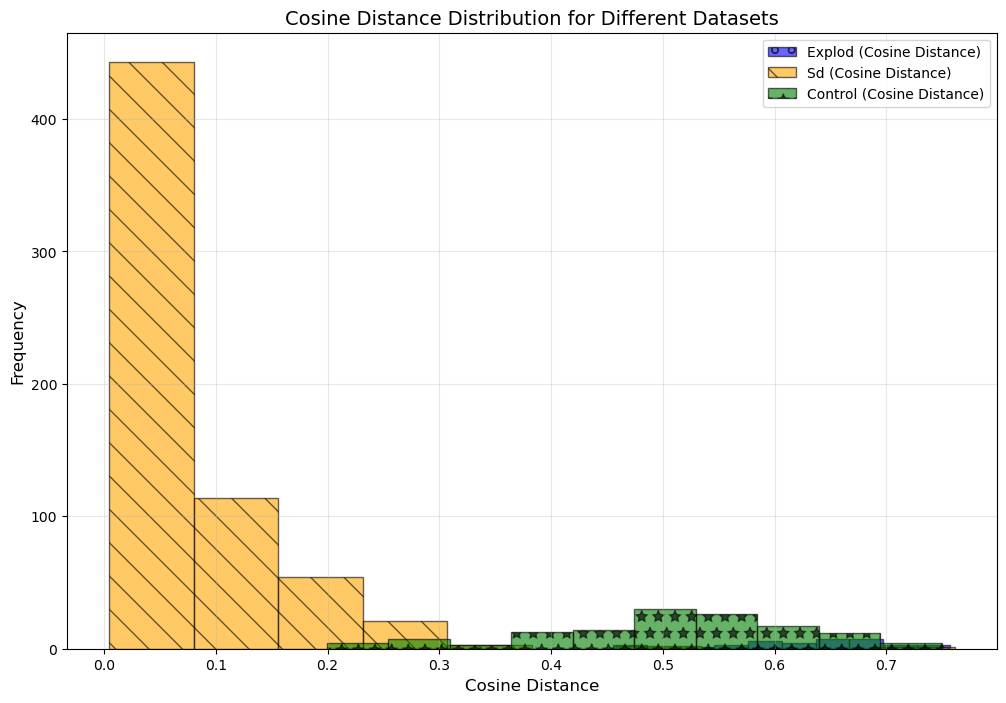

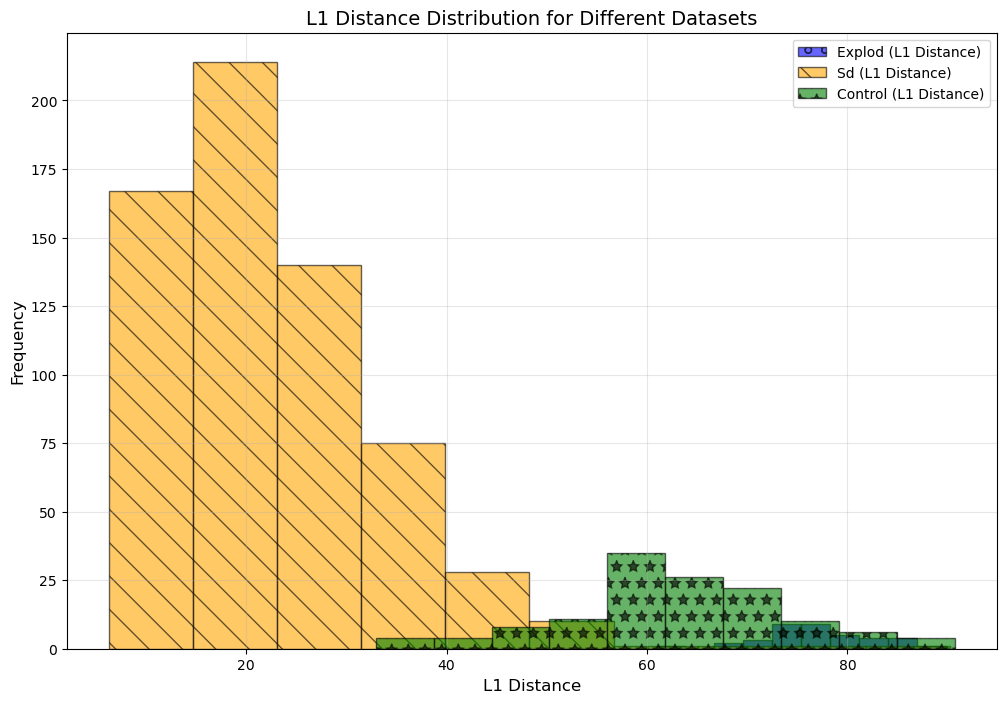

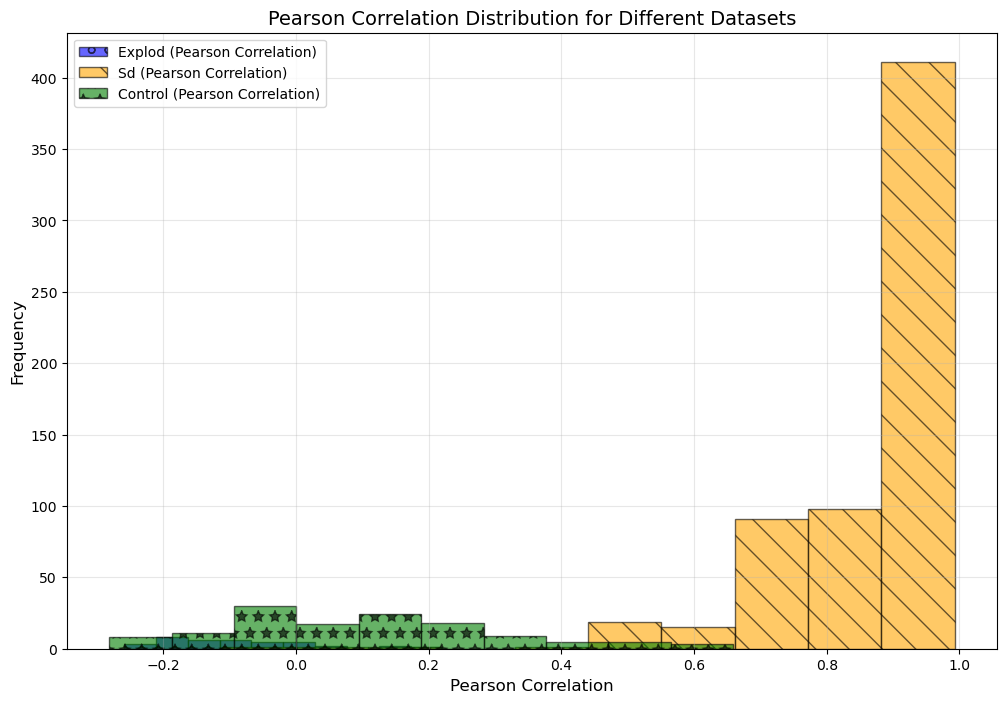

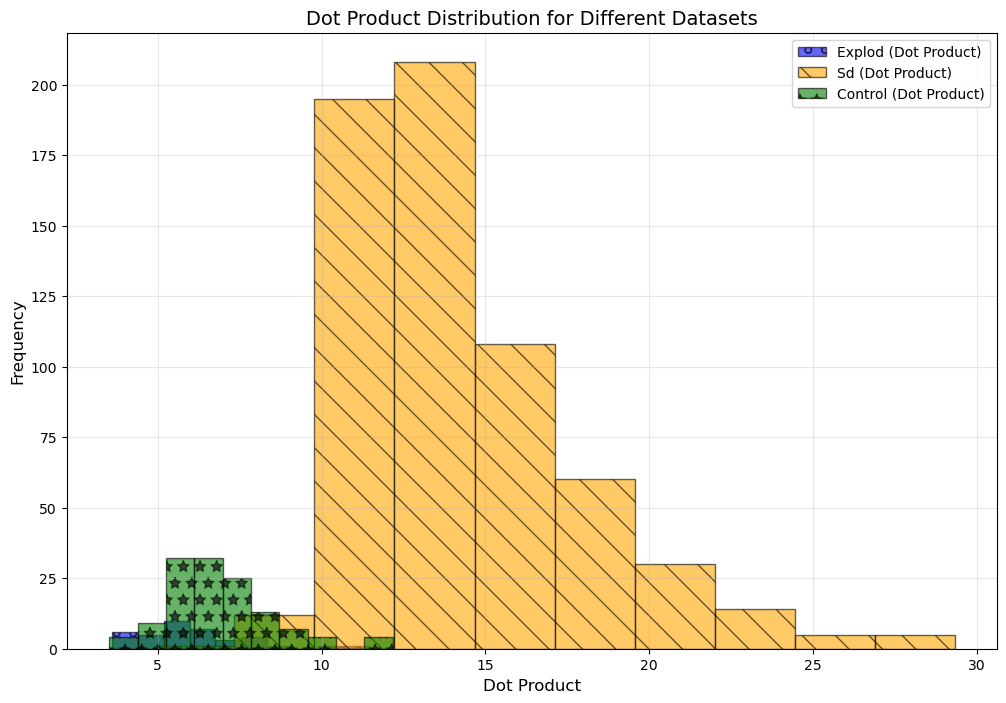

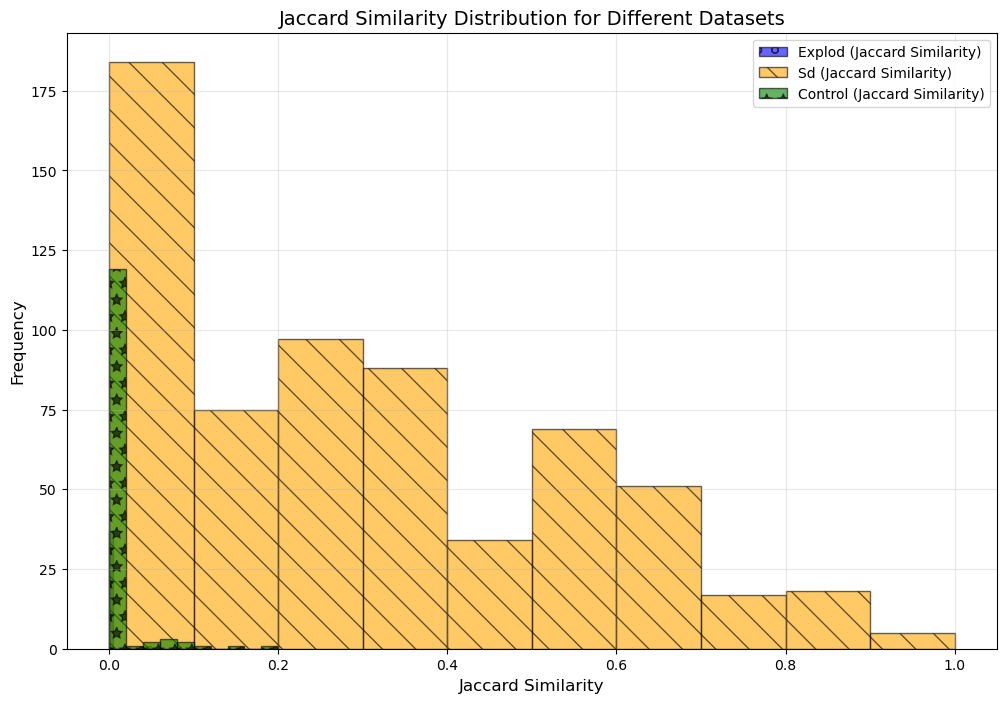

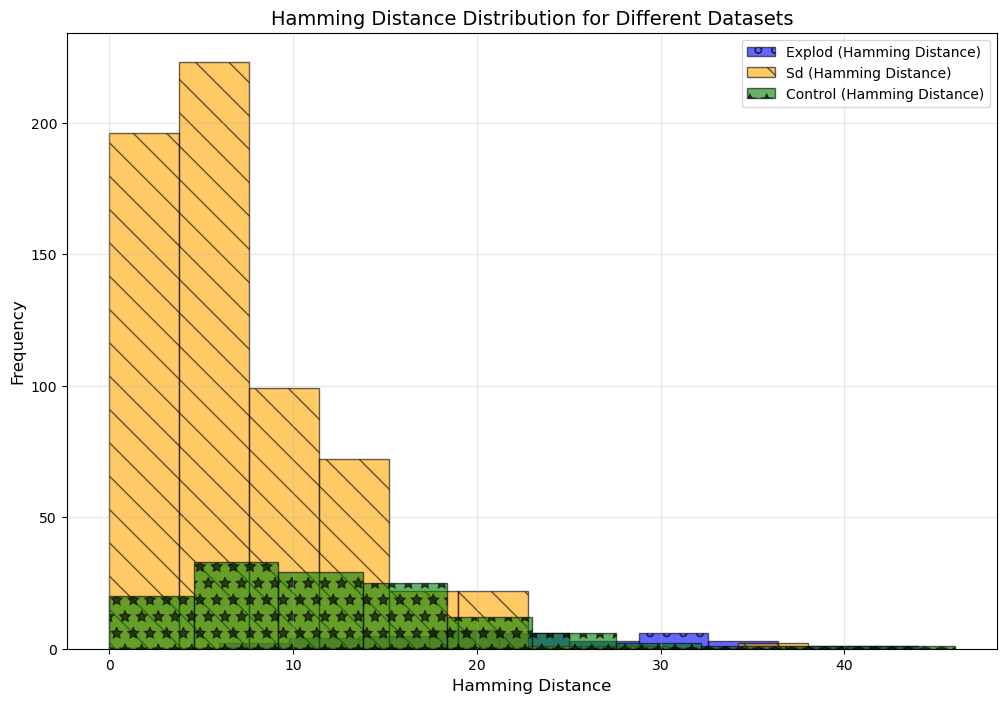

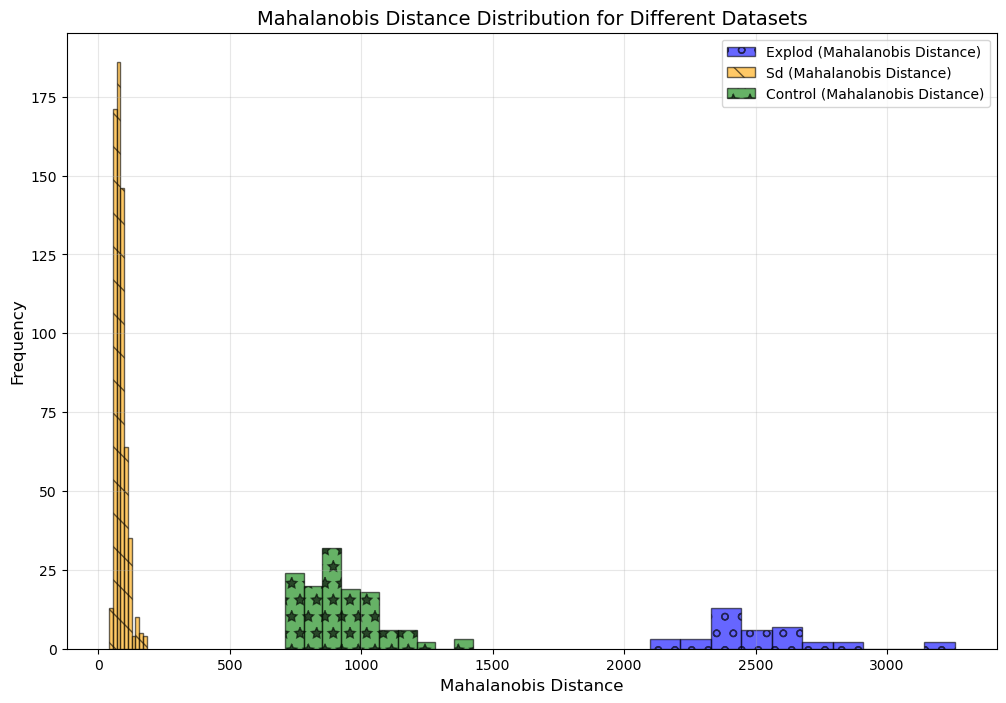

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("all_metrics_ex.csv"),
    "sd": pd.read_csv("all_metrics_combined_sd.csv"),
    "control": pd.read_csv("all_metrics_control.csv")
}

# Prepare all metrics
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance"
]

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        if metric_name in df.columns:
            values = df[metric_name].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                hatch=hatch_styles[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


# only mahalanobis


In [18]:
import torch
import torch.nn as nn

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = cond7_minmax.to(device)
train_day10_feats_minmaxed = cond10_minmax.to(device)

# Initialize the MSE loss function (if needed elsewhere in your code)
mse_loss_fn = nn.MSELoss()

# List to store Mahalanobis distances
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)

# Print some example Mahalanobis distances
print(f"Example Mahalanobis Distance for the first feature vector: {mahalanobis_distances[0]:.4f}")

Example Mahalanobis Distance for the first feature vector: 715.1381


In [19]:
import pandas as pd

# Create a DataFrame with only the Mahalanobis distances
data = {
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "mahalanobis_distances_control.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"Mahalanobis distances saved to {csv_file_name}")



Mahalanobis distances saved to mahalanobis_distances_control.csv


In [20]:
import torch
import torch.nn as nn

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = ex7_minmax.to(device)
train_day10_feats_minmaxed = ex10_minmax.to(device)

# Initialize the MSE loss function (if needed elsewhere in your code)
mse_loss_fn = nn.MSELoss()

# List to store Mahalanobis distances
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)

# Print some example Mahalanobis distances
print(f"Example Mahalanobis Distance for the first feature vector: {mahalanobis_distances[0]:.4f}")

Example Mahalanobis Distance for the first feature vector: 2882.4167


In [21]:
import pandas as pd

# Create a DataFrame with only the Mahalanobis distances
data = {
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "mahalanobis_distances_ex.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"Mahalanobis distances saved to {csv_file_name}")



Mahalanobis distances saved to mahalanobis_distances_ex.csv


In [22]:
import torch
import torch.nn as nn

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = sd7_minmax.to(device)
train_day10_feats_minmaxed = sd10_minmax.to(device)

# Initialize the MSE loss function (if needed elsewhere in your code)
mse_loss_fn = nn.MSELoss()

# List to store Mahalanobis distances
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)

# Print some example Mahalanobis distances
print(f"Example Mahalanobis Distance for the first feature vector: {mahalanobis_distances[0]:.4f}")

Example Mahalanobis Distance for the first feature vector: 335.8359


In [23]:
import pandas as pd

# Create a DataFrame with only the Mahalanobis distances
data = {
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "mahalanobis_distances_sd.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"Mahalanobis distances saved to {csv_file_name}")



Mahalanobis distances saved to mahalanobis_distances_sd.csv


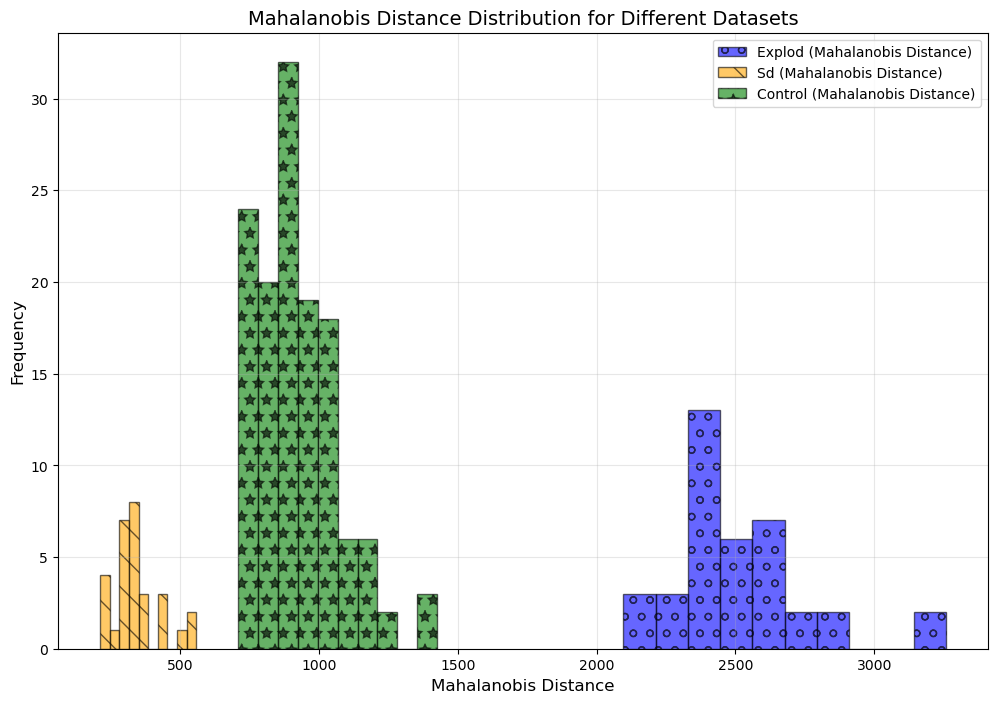

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("mahalanobis_distances_ex.csv"),  # Update with the correct file name if necessary
    "sd": pd.read_csv("mahalanobis_distances_sd.csv"),
    "control": pd.read_csv("mahalanobis_distances_control.csv")  # Update with the correct file name if necessary
}

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_mahalanobis_distribution(bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot Mahalanobis Distance for each dataset
    for dataset_name, df in datasets.items():
        if "Mahalanobis Distance" in df.columns:
            values = df["Mahalanobis Distance"].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} (Mahalanobis Distance)",
                color=colors[dataset_name],
                hatch=hatch_styles[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title("Mahalanobis Distance Distribution for Different Datasets", fontsize=14)
    plt.xlabel("Mahalanobis Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot the Mahalanobis Distance distribution
plot_mahalanobis_distribution(bins=10)


# efficient code 

In [25]:
import torch
import torch.nn as nn
import pandas as pd

def compute_and_save_mahalanobis_distances(model, day7_feats, day10_feats, file_name, device="cpu"):
    """
    Compute Mahalanobis distances and save them to a CSV file.

    Parameters:
    - model: The PyTorch model used to predict day10 features from day7 features.
    - day7_feats (torch.Tensor): Feature vectors for day 7 (shape: [N, D]).
    - day10_feats (torch.Tensor): Feature vectors for day 10 (shape: [N, D]).
    - file_name (str): Name of the CSV file to save the Mahalanobis distances.
    - device (str): The device to use for computation (e.g., "cpu" or "cuda").

    Returns:
    - None
    """
    # Ensure the tensors are on the correct device
    day7_feats = day7_feats.to(device)
    day10_feats = day10_feats.to(device)

    # Compute mean and covariance matrix for day10 features
    epsilon = 1e-6  # Stabilization constant for invertibility
    mean_vector = torch.mean(day10_feats, dim=0)  # Mean vector
    covariance_matrix = torch.cov(day10_feats.T)  # Covariance matrix
    covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
    covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

    # List to store Mahalanobis distances
    mahalanobis_distances = []

    # Loop through each feature vector in day7 features
    for i in range(day7_feats.shape[0]):
        train_day7_feats = day7_feats[i].unsqueeze(0)  # Shape: [1, D]

        # Get prediction for day10 features
        with torch.no_grad():
            predicted_day10 = model(train_day7_feats)

        # Compute Mahalanobis Distance
        delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
        mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
        mahalanobis_distances.append(mahalanobis_distance)

    # Create a DataFrame with Mahalanobis distances
    data = {"Mahalanobis Distance": mahalanobis_distances}
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv(file_name, index=False)
    print(f"Mahalanobis distances saved to {file_name}")

# Example usage
# Assuming ex7_minmax, ex10_minmax, sd7_minmax, and sd10_minmax are already loaded
# and the `model` is defined and loaded onto the appropriate device

# Call the function for each group of features
compute_and_save_mahalanobis_distances(model, ex7_minmax, ex10_minmax, "mahalanobis_distances_ex.csv", device="cuda")
compute_and_save_mahalanobis_distances(model, sd7_minmax, sd10_minmax, "mahalanobis_distances_sd.csv", device="cuda")
compute_and_save_mahalanobis_distances(model, cond7_minmax, cond10_minmax, "mahalanobis_distances_control.csv", device="cuda")


Mahalanobis distances saved to mahalanobis_distances_ex.csv
Mahalanobis distances saved to mahalanobis_distances_sd.csv
Mahalanobis distances saved to mahalanobis_distances_control.csv


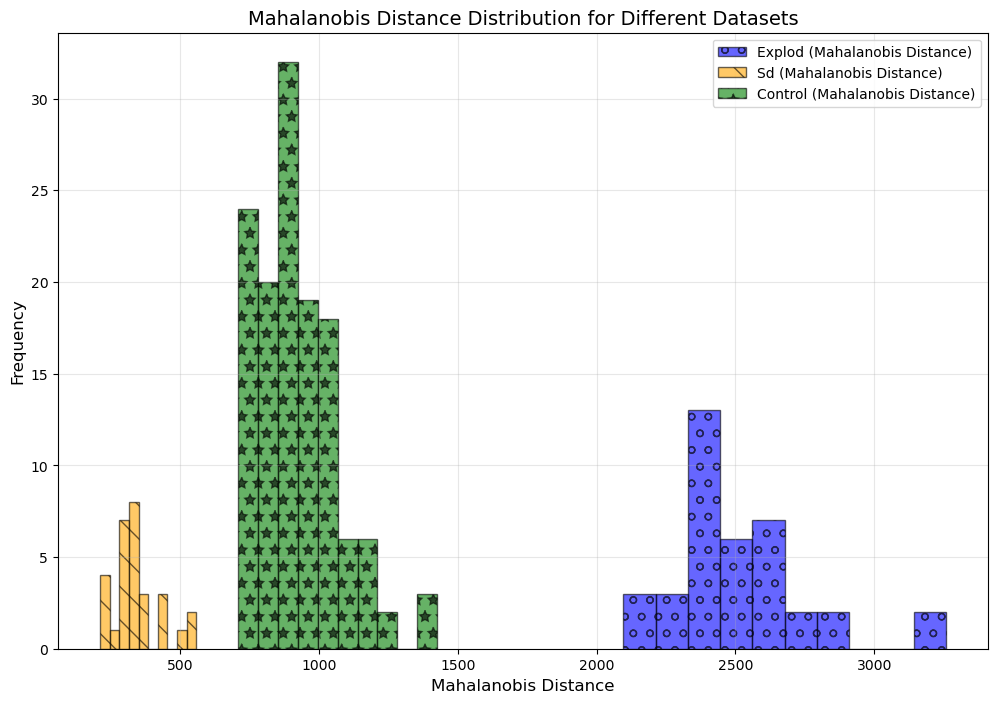

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("mahalanobis_distances_ex.csv"),  # Update with the correct file name if necessary
    "sd": pd.read_csv("mahalanobis_distances_sd.csv"),
    "control": pd.read_csv("mahalanobis_distances_control.csv")  # Update with the correct file name if necessary
}

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_mahalanobis_distribution(bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot Mahalanobis Distance for each dataset
    for dataset_name, df in datasets.items():
        if "Mahalanobis Distance" in df.columns:
            values = df["Mahalanobis Distance"].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} (Mahalanobis Distance)",
                color=colors[dataset_name],
                hatch=hatch_styles[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title("Mahalanobis Distance Distribution for Different Datasets", fontsize=14)
    plt.xlabel("Mahalanobis Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot the Mahalanobis Distance distribution
plot_mahalanobis_distribution(bins=10)
